In [1]:
import numpy as np
import cPickle as pickle

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms

from matplotlib.ticker import NullFormatter, ScalarFormatter, NullLocator, AutoLocator, MultipleLocator

class SqrtScale(mscale.ScaleBase):
    # The name under which this scale will be registered with matplotlib.
    name = 'sqrt'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def get_transform(self):
        return self.SqrtTransform()

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(AutoLocator())
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_locator(NullLocator())
        axis.set_minor_formatter(NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return max(vmin, 0.0), vmax

    class SqrtTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            masked = np.ma.masked_where((a < 0.0), a)
            if masked.mask.any():
                return ma.sqrt(masked)
            else:
                return np.sqrt(a)

        def inverted(self):
            return SqrtScale.InvertedSqrtTransform()

    class InvertedSqrtTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self):
            mtransforms.Transform.__init__(self)

        def transform_non_affine(self, a):
            return a**2

        def inverted(self):
            return SqrtScale.SqrtTransform()

mscale.register_scale(SqrtScale)

def plot_regret_curves(ax, info, regret, xscale=None, yscale=None):
    ranker_model_name = info['ranking_model'].getName()
    click_model_name = info['click_model'].getName()
    cutoff = info['cutoff']
    qid = info['query']
    regret = regret.cumsum()
    
    xscale = 'linear' if xscale is None else xscale
    yscale = 'linear' if yscale is None else yscale
    
    # Subsample regret if there is more than 10^5 iterations.
    if regret.shape[0] > 100000:
        indices = np.linspace(0, regret.shape[0] - 1, 100000).astype('int32')
        regret = regret[indices]
    else:
        indices = np.arange(regret.shape[0], dtype='int32')

    ax.set_title('%s - %s@%d - Q%s (%s Regret Plot)' % (ranker_model_name, click_model_name, cutoff, qid,
                                                       xscale.capitalize()  + '-' + yscale.capitalize()))

    ax.plot(indices, regret, 'k-')

    ax.set_ylabel('Regret - (CTR@%d)' % cutoff)
    ax.set_xlabel('Impressions')

    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

    ax.title.set_fontsize(10)

    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)

    ax.xaxis.get_offset_text().set_fontsize(10)
    ax.yaxis.get_offset_text().set_fontsize(10)

    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)

def plot_average_regret_curves(ax, info, regret, xscale=None, yscale=None):
    '''
    Plots the regret curves for the experiment described in `info` with axis
    scaled according to `xscale` and `yscale` respecitvely.
    
    Parameters
    ----------
    ax: instance of matplotlib's axes
        Target axes to plot the curves into.

    info:
        The description of the experiment.

    regret: array, shape = [4, n_impressions]
        Matrix containing 4 row vectors storing mean, std, minima, and maxima
        of cumulative regret, respectively.
    '''
    ranker_model_name = info['ranking_model'].getName()
    click_model_name = info['click_model'].getName()
    cutoff = info['cutoff']
    qid = info['query']
    
    xscale = 'linear' if xscale is None else xscale
    yscale = 'linear' if yscale is None else yscale
    
    # Subsample regret if there is more than 10^5 iterations.
    if regret[1].shape[0] > 100000:
        indices = np.linspace(0, regret[1].shape[0] - 1, 100000).astype('int32')
        regret = regret[:, indices]
    else:
        indices = np.arange(regret.shape[0], dtype='int32')

    ax.set_title('%s - %s@%d - Q%s (%s Regret Plot)' % (ranker_model_name, click_model_name, cutoff, qid,
                                                       xscale.capitalize()  + '-' + yscale.capitalize()))

    ax.fill_between(indices, regret[2], regret[0] - regret[1], facecolor='red', edgecolor='none',
                    alpha=0.2, interpolate=True)
    
    ax.fill_between(indices, regret[0] - regret[1], regret[0] + regret[1], facecolor='blue',
                    edgecolor='none', alpha=0.2, interpolate=True)
    
    ax.fill_between(indices, regret[0] + regret[1], regret[3], facecolor='red', edgecolor='none',
                    alpha=0.2, interpolate=True)
    
    ax.plot(indices, regret[0], 'k-')

    ax.set_ylabel('Regret - (CTR@%d)' % cutoff)
    ax.set_xlabel('Impressions')

    ax.set_xscale(xscale)
    ax.set_yscale(yscale)

    ax.title.set_fontsize(10)

    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)

    ax.xaxis.get_offset_text().set_fontsize(10)
    ax.yaxis.get_offset_text().set_fontsize(10)

    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)

with open('data/model_query_collection.pkl') as ifile:
    MQD = pickle.load(ifile)

## Save Figures of Cumulative Regret Curves for Ranking and Click Model Pairs

# Cumulative Regret Curves for Ranking and Click Model Pairs

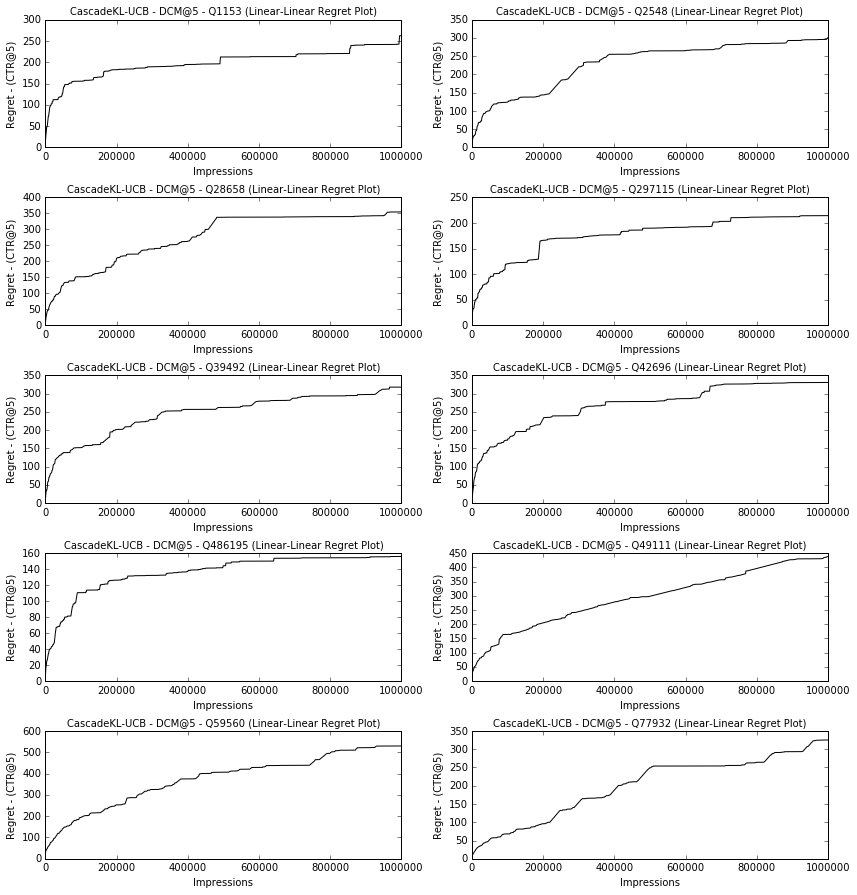

In [2]:
import os
import cPickle as pickle
from ipywidgets import Select, Dropdown, interactive, HBox
from IPython.display import display

# Change this to force the visualization of experiments under this directory.
EXPERIMENTS_DIRECTORY = "experiments/CascadeKLUCBAlgorithm/run1"

def get_regret_filepath(experiment_info_filepath):
    return experiment_info_filepath.rstrip('experiment.nfo') + 'regret.npy'

def show_regrets_widget():
    experiment_filepaths = []
    experiment_specs = []

    def show_regrets(ranking_model_name, click_model_name, xscale, yscale):
        spec_indices = [i for i, spec in enumerate(experiment_specs)
                        if spec['click_model'].getName() == click_model_name and
                        spec['ranking_model'].getName() == ranking_model_name and
                        os.path.exists(get_regret_filepath(experiment_filepaths[i]))]
        
        specs, spec_indices = zip(*sorted([(experiment_specs[i], i) for i in spec_indices],
                                          key=lambda info: info[0]['query']))
        regrets = [np.load(get_regret_filepath(experiment_filepaths[i])) for i in spec_indices]

        n_rows = (len(specs) + 1) / 2
        n_cols = 2 if len(specs) > 1 else 1
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 2.5 * n_rows))
        
        axes = axes.ravel() if len(specs) > 1 else [axes]
        
        for ax, info, regret in zip(axes, specs, regrets):
            plot_regret_curves(ax, info, regret, xscale=xscale, yscale=yscale)
        
        if len(specs) > 1 and len(specs) % 2 == 1:
            axes[-1].axis('off')

        plt.tight_layout()
        plt.show()   

    for root, dirs, files in os.walk(EXPERIMENTS_DIRECTORY, topdown=True):
        for fn in files:
            if fn.endswith('.nfo'):
                fp = os.path.join(root, fn)
                experiment_filepaths.append(fp)
                with open(fp) as ifile:
                    experiment_specs.append(pickle.load(ifile))
    
    ranking_model_names = set([spec['ranking_model'].getName() for spec in experiment_specs])
    click_model_names = set([spec['click_model'].getName() for spec in experiment_specs])

    rmdd = Select(options=list(ranking_model_names), description='Ranking Model:', width='150px')
    cmdd = Select(options=list(click_model_names), description='Click Model:', width='75px')
    xsdd = Select(options=['linear', 'sqrt', 'log'], description='X Scale:', width='100px', height='65px')
    ysdd = Select(options=['linear', 'sqrt', 'log'], description='Y Scale:', width='100px', height='65px')
    
    controls = HBox([rmdd, cmdd, xsdd, ysdd])
    backend = interactive(show_regrets, ranking_model_name=rmdd, click_model_name=cmdd,
                          xscale=xsdd, yscale=ysdd)

    controls.on_displayed(lambda _: show_regrets(rmdd.value, cmdd.value, xsdd.value, ysdd.value))

    display(controls)

show_regrets_widget()

# Cumulative Regret Curves for Ranking and Click Model Pairs

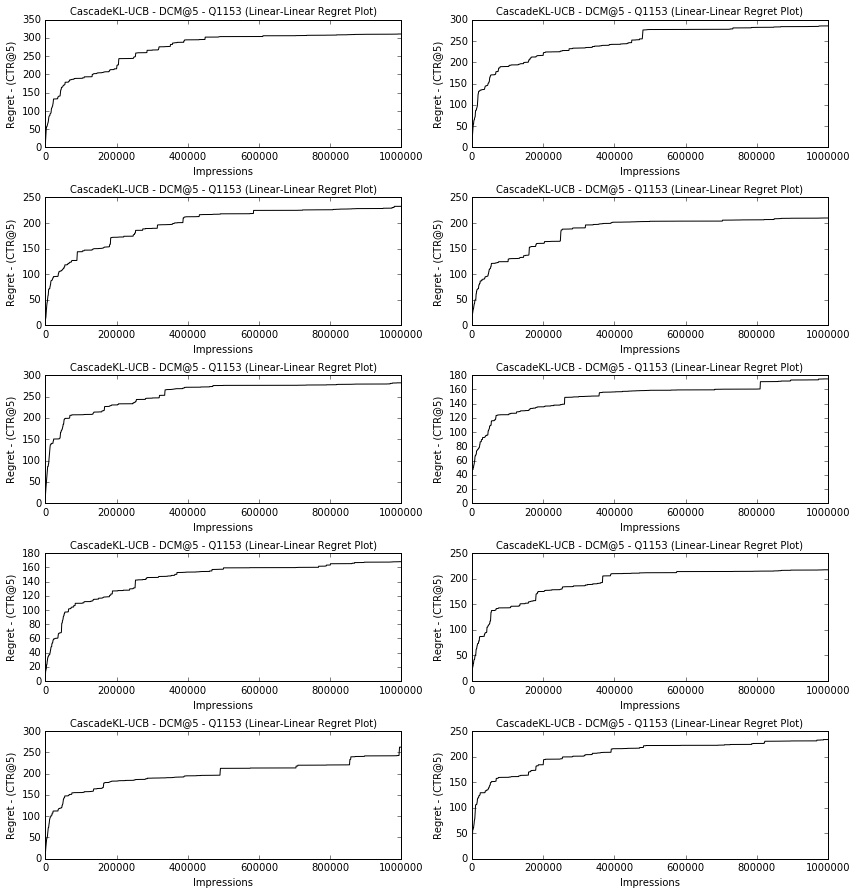

In [3]:
import os
import cPickle as pickle
from ipywidgets import Select, Dropdown, interactive, HBox
from IPython.display import display

# Change this to force the visualization of experiments under this directory.
EXPERIMENTS_DIRECTORY = "experiments/CascadeKLUCBAlgorithm"

def get_regret_filepath(experiment_info_filepath):
    return experiment_info_filepath.rstrip('experiment.nfo') + 'regret.npy'

def show_regrets_widget():
    experiment_filepaths = []
    experiment_specs = []
    
    def show_regrets(query, click_model_name, xscale, yscale):
        spec_indices = [i for i, spec in enumerate(experiment_specs)
                        if spec['click_model'].getName() == click_model_name and
                        spec['query'] == query and
                        os.path.exists(get_regret_filepath(experiment_filepaths[i]))]

        specs, spec_indices = zip(*sorted([(experiment_specs[i], i) for i in spec_indices],
                                          key=lambda info: info[0]['query']))
        regrets = [np.load(get_regret_filepath(experiment_filepaths[i])) for i in spec_indices]

        n_rows = (len(specs) + 1) / 2
        n_cols = 2 if len(specs) > 1 else 1
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 2.5 * n_rows))
        
        axes = axes.ravel() if len(specs) > 1 else [axes]
        
        for ax, info, regret in zip(axes, specs, regrets):
            plot_regret_curves(ax, info, regret, xscale=xscale, yscale=yscale)
        
        if len(specs) > 1 and len(specs) % 2 == 1:
            axes[-1].axis('off')
            
        plt.tight_layout()
        plt.show()   

    for root, dirs, files in os.walk(EXPERIMENTS_DIRECTORY, topdown=True):
        for fn in files:
            if fn.endswith('.nfo'):
                fp = os.path.join(root, fn)
                experiment_filepaths.append(fp)
                with open(fp) as ifile:
                    experiment_specs.append(pickle.load(ifile))
    
    queries = sorted(set([spec['query'] for spec in experiment_specs]))
    click_model_names = set([spec['click_model'].getName() for spec in experiment_specs])

    qdd = Select(options=list(queries), description='Queries:', width='150px', height='175px')
    cmdd = Select(options=list(click_model_names), description='Click Model:', width='75px')
    xsdd = Select(options=['linear', 'sqrt', 'log'], description='X Scale:', width='100px', height='65px')
    ysdd = Select(options=['linear', 'sqrt', 'log'], description='Y Scale:', width='100px', height='65px')
    
    controls = HBox([qdd, cmdd, xsdd, ysdd])
    backend = interactive(show_regrets, query=qdd, click_model_name=cmdd, xscale=xsdd, yscale=ysdd)

    controls.on_displayed(lambda _: show_regrets(qdd.value, cmdd.value, xsdd.value, ysdd.value))

    display(controls)

show_regrets_widget()

# Average Cumulative Regret Curves for Single Ranking Algorithm

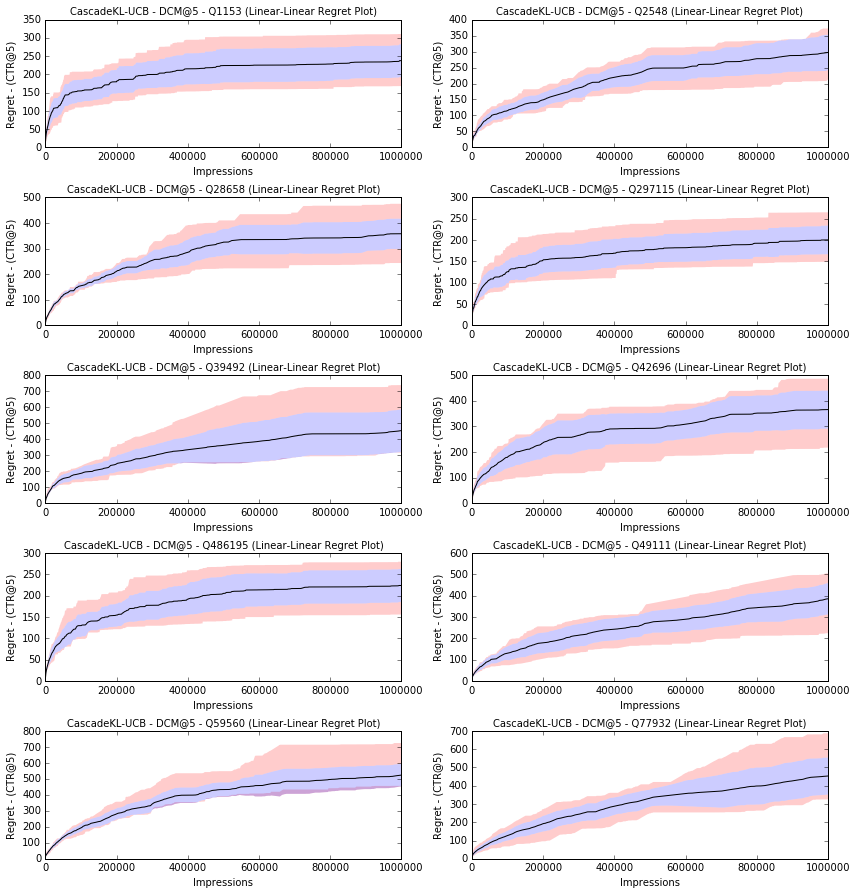

In [4]:
import os
import cPickle as pickle
from ipywidgets import Select, Dropdown, interactive, HBox
from IPython.display import display

# Change this to force the visualization of experiments under this directory.
EXPERIMENTS_DIRECTORY = "experiments/CascadeKLUCBAlgorithm"

def get_regret_filepath(experiment_info_filepath):
    return experiment_info_filepath.rstrip('experiment.nfo') + 'regret.npy'

def show_regrets_widget():
    experiment_filepaths = []
    experiment_specs = []
    experiment_regrets = []

    def show_regrets(click_model_name, xscale, yscale):
        spec_indices = [i for i, spec in enumerate(experiment_specs)
                        if spec['click_model'].getName() == click_model_name and
                        os.path.exists(get_regret_filepath(experiment_filepaths[i]))]

        specs, spec_indices = zip(*sorted([(experiment_specs[i], i) for i in spec_indices],
                                              key=lambda info: info[0]['query']))
        regrets = [experiment_regrets[i] for i in spec_indices]

        n_rows = (len(specs) + 1) / 2
        n_cols = 2 if len(specs) > 1 else 1

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 2.5 * n_rows))

        axes = axes.ravel() if len(specs) > 1 else [axes]

        for ax, info, regret in zip(axes, specs, regrets):
            plot_average_regret_curves(ax, info, regret, xscale=xscale, yscale=yscale)

        if len(specs) > 1 and len(specs) % 2 == 1:
            axes[-1].axis('off')

        plt.tight_layout()
        plt.show()

    for root, dirs, files in os.walk(EXPERIMENTS_DIRECTORY, topdown=True):
        for fn in files:
            if fn.endswith('.nfo'):
                fp = os.path.join(root, fn)
                experiment_filepaths.append(fp)
                with open(fp) as ifile:
                    experiment_specs.append(pickle.load(ifile))

    regret_collection = {}
    
    for fp, spec in zip(experiment_filepaths, experiment_specs):
        query_click = (spec['query'], spec['click_model'].getName())
        if query_click not in regret_collection:
            regret_collection[query_click] = (spec, [])
        regret_collection[query_click][1].append(np.load(get_regret_filepath(fp)))

    experiment_specs = []
    
    for query_click in regret_collection.keys():
        experiment_specs.append(regret_collection[query_click][0])
        regrets = np.vstack(regret_collection[query_click][1]).cumsum(axis=1)
        experiment_regrets.append(np.vstack([regrets.mean(axis=0),
                                             regrets.std(axis=0),
                                             regrets.min(axis=0),
                                             regrets.max(axis=0)]))
        del regret_collection[query_click]
    
    del regret_collection
        
    click_model_names = set([spec['click_model'].getName() for spec in experiment_specs])

    cmdd = Select(options=list(click_model_names), description='Click Model:', width='75px')
    xsdd = Select(options=['linear', 'sqrt', 'log'], description='X Scale:', width='100px', height='65px')
    ysdd = Select(options=['linear', 'sqrt', 'log'], description='Y Scale:', width='100px', height='65px')
    
    controls = HBox([cmdd, xsdd, ysdd])
    backend = interactive(show_regrets, click_model_name=cmdd, xscale=xsdd, yscale=ysdd)

    controls.on_displayed(lambda _: show_regrets(cmdd.value, xsdd.value, ysdd.value))

    display(controls)

show_regrets_widget()

# Cumulative Regret Curves for Query and Specific Ranking Model

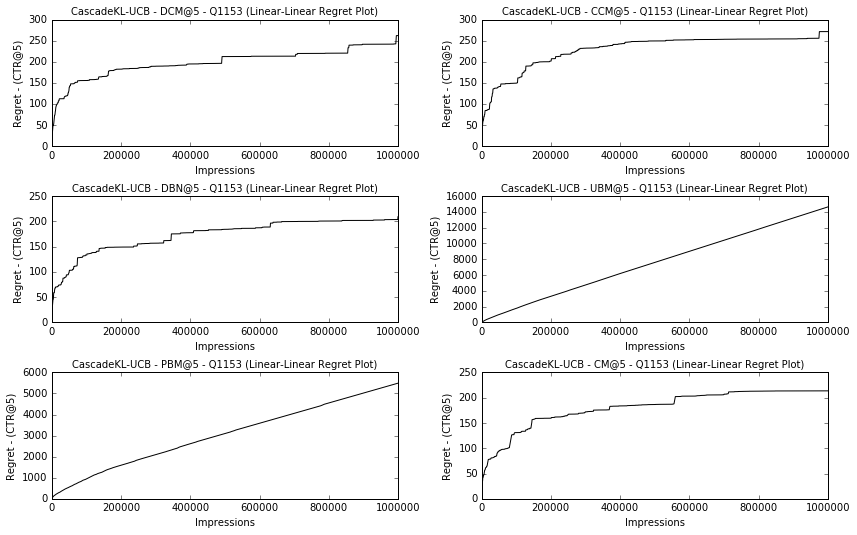

In [5]:
import os
import cPickle as pickle
from ipywidgets import Select, Dropdown, interactive, HBox
from IPython.display import display

# Change this to force the visualization of experiments under this directory.
EXPERIMENTS_DIRECTORY = "experiments/CascadeKLUCBAlgorithm/run1"

def get_regret_filepath(experiment_info_filepath):
    return experiment_info_filepath.rstrip('experiment.nfo') + 'regret.npy'

def show_regrets_widget():
    experiment_filepaths = []
    experiment_specs = []
    experiment_regrets = []

    def show_regrets(query, xscale, yscale):
        spec_indices = [i for i, spec in enumerate(experiment_specs)
                        if spec['query'] == query and
                        os.path.exists(get_regret_filepath(experiment_filepaths[i]))]

        specs, spec_indices = zip(*sorted([(experiment_specs[i], i) for i in spec_indices],
                                              key=lambda info: info[0]['query']))
        regrets = [experiment_regrets[i] for i in spec_indices]

        n_rows = (len(specs) + 1) / 2
        n_cols = 2 if len(specs) > 1 else 1

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 2.5 * n_rows))

        axes = axes.ravel() if len(specs) > 1 else [axes]

        for ax, info, regret in zip(axes, specs, regrets):
            plot_average_regret_curves(ax, info, regret, xscale=xscale, yscale=yscale)

        if len(specs) > 1 and len(specs) % 2 == 1:
            axes[-1].axis('off')

        plt.tight_layout()
        plt.show()

    for root, dirs, files in os.walk(EXPERIMENTS_DIRECTORY, topdown=True):
        for fn in files:
            if fn.endswith('.nfo'):
                fp = os.path.join(root, fn)
                experiment_filepaths.append(fp)
                with open(fp) as ifile:
                    experiment_specs.append(pickle.load(ifile))

    regret_collection = {}
    
    for fp, spec in zip(experiment_filepaths, experiment_specs):
        query_click = (spec['query'], spec['click_model'].getName())
        if query_click not in regret_collection:
            regret_collection[query_click] = (spec, [])
        regret_collection[query_click][1].append(np.load(get_regret_filepath(fp)))

    experiment_specs = []
    
    for query_click in regret_collection.keys():
        experiment_specs.append(regret_collection[query_click][0])
        regrets = np.vstack(regret_collection[query_click][1]).cumsum(axis=1)
        experiment_regrets.append(np.vstack([regrets.mean(axis=0),
                                             regrets.std(axis=0),
                                             regrets.min(axis=0),
                                             regrets.max(axis=0)]))
        del regret_collection[query_click]
    
    del regret_collection
        
    queries = sorted(set([spec['query'] for spec in experiment_specs]))
    
    qdd = Select(options=list(queries), description='Queries:', width='150px', height='175px')
    xsdd = Select(options=['linear', 'sqrt', 'log'], description='X Scale:', width='100px', height='65px')
    ysdd = Select(options=['linear', 'sqrt', 'log'], description='Y Scale:', width='100px', height='65px')
    
    controls = HBox([qdd, xsdd, ysdd])
    backend = interactive(show_regrets, query=qdd, xscale=xsdd, yscale=ysdd)

    controls.on_displayed(lambda _: show_regrets(qdd.value, xsdd.value, ysdd.value))

    display(controls)

show_regrets_widget()

# Click Model Attractiveness Probabilities of Documents 

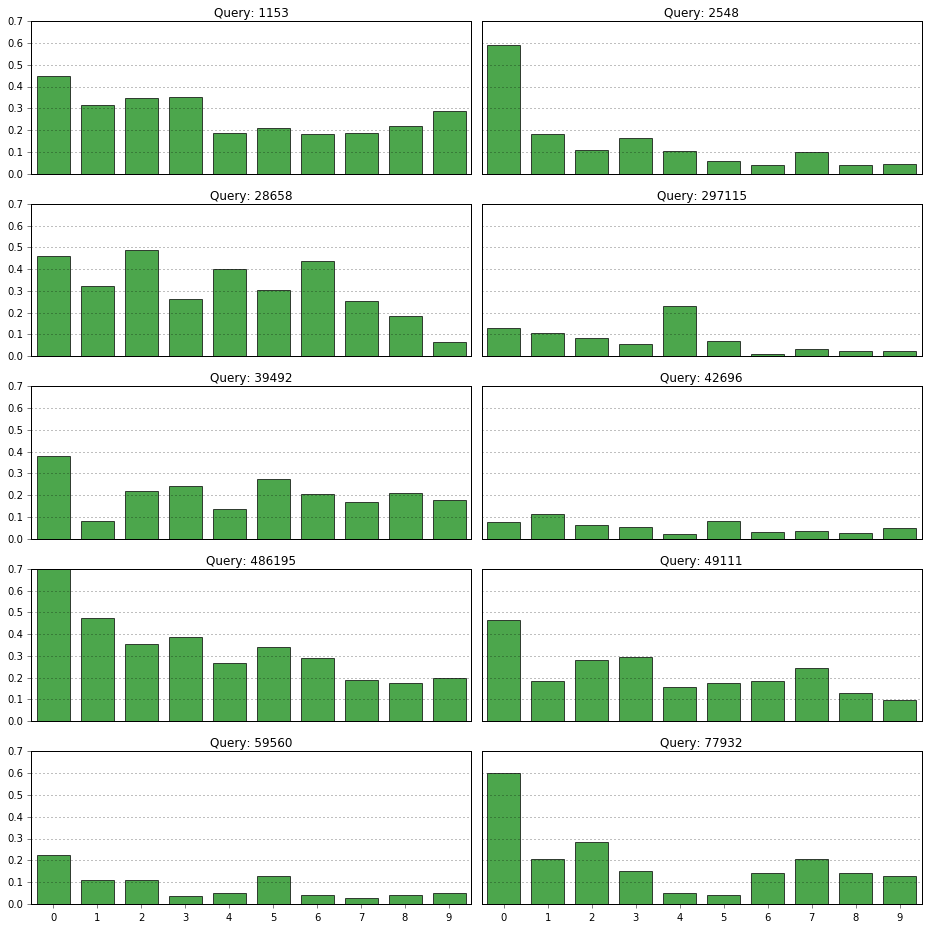

In [6]:
from ipywidgets import interact, interactive, Dropdown, FloatText, VBox, HBox

from IPython.display import display

def show_all_queries_relevances(click_model_name):
    fig, axes = plt.subplots(5, 2, figsize=(13, 13), sharex=True, sharey=True)

    for i, query in enumerate(sorted(MQD[click_model_name].keys())):
        ax = axes[i / 2, i % 2]

        relevances = MQD[click_model_name][query]['relevances']

        ax.bar(np.arange(len(relevances)), relevances, 0.75,
               alpha=0.7, color='green', align='center')

        ax.set_title('Query: %s' % query)
        ax.grid(axis='y', which='major')
        
        b = 'on' if i / 2 == 4 else 'off'
        lb = 'on' if i / 2 == 4 else 'off'
        l = 'on' if i % 2 == 0 else 'off'
        ll = 'on' if i % 2 == 0 else 'off'
                
        ax.tick_params(axis='both', which='major', left=l, direction='out',
                       top='off', right='off', bottom=b, labelleft=ll,
                       labeltop='off', labelright='off', labelbottom=lb)
            
    ax.xaxis.set_major_locator(MultipleLocator(1.0))
    ax.set_xlim([-0.5, len(relevances) - 0.5])
    plt.tight_layout()
    plt.show(fig)

_ = interact(show_all_queries_relevances, click_model_name=Dropdown(options=MQD.keys(), description='Click Model:'))